# Introduction: Play with GLMs
During my study at [HSLU](https://www.hslu.ch/en/lucerne-school-of-business/degree-programmes/master/applied-information-and-data-science/) I have learned to use mostly [`R`](https://www.r-project.org/) when it comes to statistic and for some machine learning courses as well. When it comes to work, the most companies I have seen so far, use `Python` as their main programming language. My previous two employers used `Python` and `R`. __This article is not going to discuss which language is better, but rather focus on how to use `Python` and the library `statmodels` which seems to produce similar outputs as it would in `R`.__

One important and cool thing about the `statmodels` library is that it has a lot of data sets already included. You can find them [here](https://www.statsmodels.org/stable/datasets/index.html). The data set I use is a `R` data set from [Rdatasets](https://vincentarelbundock.github.io/Rdatasets/). In particular, the dataset from the package `modeldata` called `car_prices` is used.

```python
## Data imports
df = (
    statsmodels.api # imported as sm in following code
    .datasets
    .get_rdataset("car_prices", package='modeldata')
    .data
)
```

Another important thing about this blog post is the usage of [`Quarto`](https://quarto.org/). Quarto allowed me to write this blog post directly from a Jupyter-Notebook without any fancy and complicated transformations. For more information, please visit the quarto website.

However, let's start with the analysis. The first thing we do is to import the necessary libraries and the data set.


In [1]:
#| label: code
#| output: true
#| include: true
#| code-fold: false

## General imports
import warnings
warnings.filterwarnings('ignore')

## Data manipulation imports
import pandas as pd
import numpy as np

## Display imports
from IPython.display import display, Markdown

## statmodels import
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.genmod.families.family as fam
from patsy import dmatrices

## Plot imports
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (5,5/2.5)
import seaborn as sns
sns.set_style('whitegrid')
sns.set_theme()
sns.set_context(
    "paper", 
    rc={
        "figsize"       :   plt.rcParams['figure.figsize'],
        'font_scale'    :   1.25,
    }
)


## Data imports
df = (
    sm
    .datasets
    .get_rdataset(
        "car_prices", 
        package='modeldata',
    )
    .data
)

# Explanatory Data Exploration
The data exploration is a crucial step before fitting a model. It allows to understand the data and to identify potential problems. In this notebook, we will explore very briefly the data, as the focus of this article is to understand and apply `statmodels`. 

In [2]:
#| echo: false

display(Markdown(
f"""
The data set contains {df.shape[0]} observations (rows) and {df.shape[1]} predictors (columns). The data set contains information about car prices and the variables are described as follows:
{'; '.join(df.columns[:-1])}; and {''.join(df.columns[-1])}.
"""
))


The data set contains 804 observations (rows) and 18 predictors (columns). The data set contains information about car prices and the variables are described as follows:
Price; Mileage; Cylinder; Doors; Cruise; Sound; Leather; Buick; Cadillac; Chevy; Pontiac; Saab; Saturn; convertible; coupe; hatchback; sedan; and wagon.


In [3]:
#| output: false
#| echo: false
#| include: false

df.head()

,Price,Mileage,Cylinder,Doors,Cruise,Sound,Leather,Buick,Cadillac,Chevy,Pontiac,Saab,Saturn,convertible,coupe,hatchback,sedan,wagon
0,22661.05,20105,6,4,1,0,0,1,0,0,0,0,0,0,0,0,1,0
1,21725.01,13457,6,2,1,1,0,0,0,1,0,0,0,0,1,0,0,0
2,29142.71,31655,4,2,1,1,1,0,0,0,0,1,0,1,0,0,0,0
3,30731.94,22479,4,2,1,0,0,0,0,0,0,1,0,1,0,0,0,0
4,33358.77,17590,4,2,1,1,1,0,0,0,0,1,0,1,0,0,0,0


First, two approximately continous variables `Price` and `Mileage` are investigated by means of graphical analysis. The following bar plots show the distribution of the two variables.

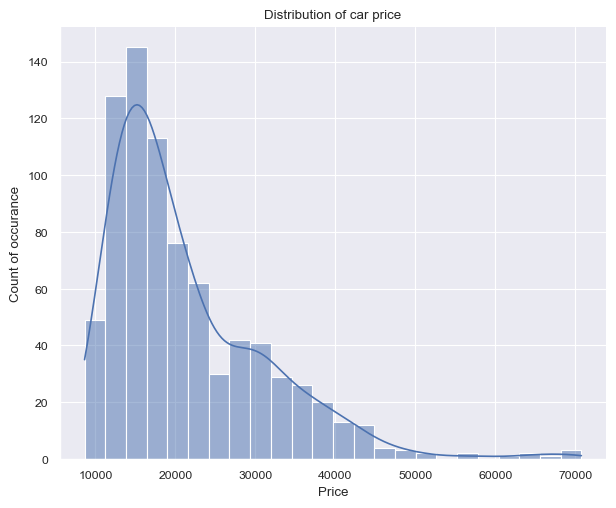

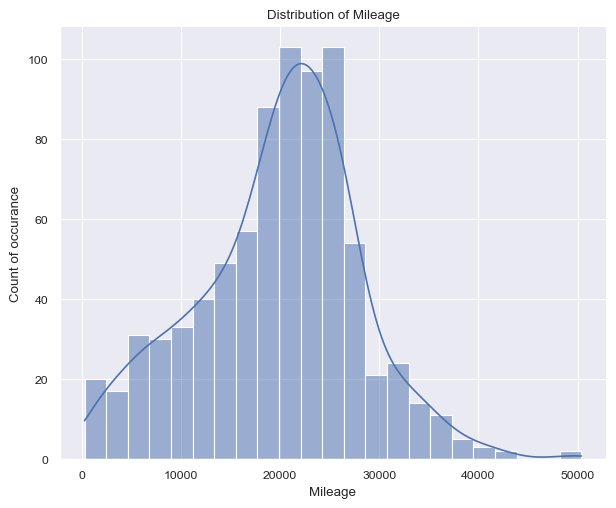

In [4]:
#| label: fig-distplot
#| layout-ncol: 2
#| fig-cap: Distribution of price and mileage variables. 
#| fig-subcap: 
#|   - "Distribution of the variable Price"
#|   - "Distribution of the variable Mileage"

height = plt.rcParams['figure.figsize'][0]
aspect = plt.rcParams['figure.figsize'][0]/plt.rcParams['figure.figsize'][1] / 2

g1 = sns.displot(
    data = df,
    x = 'Price',
    kde = True,
    height = height,
    aspect = aspect,
)
plt.title('Distribution of car price')
plt.xlabel('Price')
plt.ylabel('Count of occurance')
plt.show(g1)

g2 = sns.displot(
    data = df,
    x = 'Mileage',
    kde = True,
    height = height,
    aspect = aspect,
)
plt.title('Distribution of Mileage')
plt.xlabel('Mileage')
plt.ylabel('Count of occurance')
plt.show(g2)

@fig-distplot-1 shows on the left a right-skewed distribution with a peak around 15k$ and price values ranging from 8k dollars to 70k dollars. On the other hand, [figure -@fig-distplot-2] shows on the right a more ballanced distribution with a peak around 20k$ and price values ranging from 266 miles up to 50k miles. 

Proceeding to the next two variables, `Cylinder` and `Doors`, one can see less possible values, ranging from 

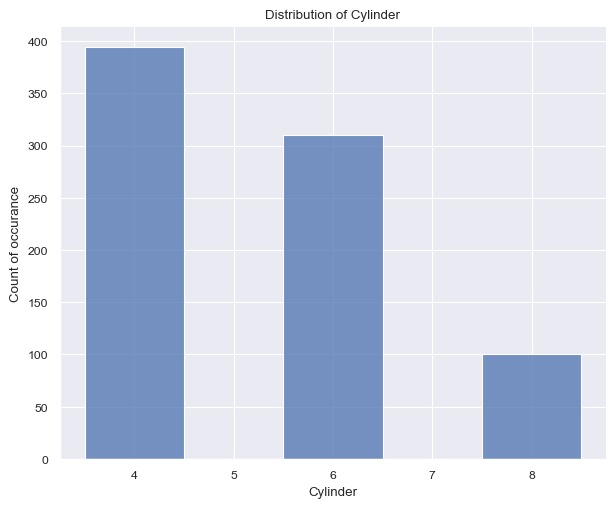

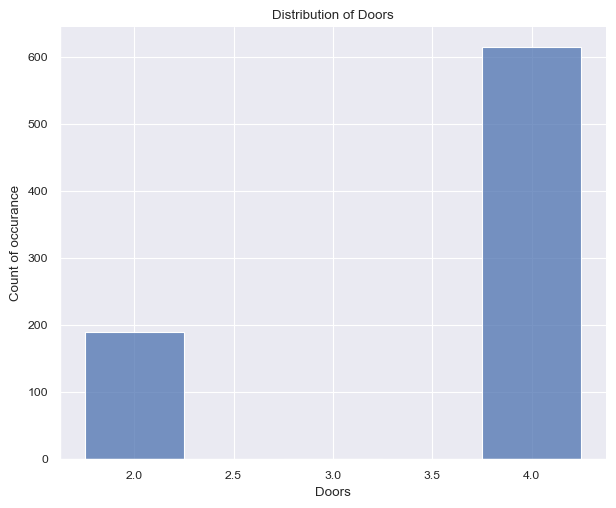

In [5]:
#| label: fig-distplot2
#| layout-ncol: 2
#| fig-cap: Distribution of cylinder and doors variables. 
#| fig-subcap: 
#|   - "Distribution of the variable cylinder"
#|   - "Distribution of the variable doors"

height = plt.rcParams['figure.figsize'][0]
aspect = plt.rcParams['figure.figsize'][0]/plt.rcParams['figure.figsize'][1] / 2

g = sns.displot(
    data = df,
    x = 'Cylinder',
    discrete = True,
    height = height,
    aspect = aspect,
)
plt.title('Distribution of Cylinder')
plt.xlabel('Cylinder')
plt.ylabel('Count of occurance')
plt.show(g)

# plt.figure()
g = sns.displot(
    data = df,
    x = 'Doors',
    discrete = True,
    shrink = 0.5,
    height = height,
    aspect = aspect,
)
plt.title('Distribution of Doors')
plt.xlabel('Doors')
plt.ylabel('Count of occurance')
plt.show(g)

The @fig-distplot2-1 surprised me quite a bit. I had anticipated the car to feature more than 8 cylinders, given that this dataset pertains to American cars. The cylinder count typically spans from 4 to 8, with the values accurately reflecting this range. It's worth noting that the number of cylinders is expected to be even.

Again surprisingly, the @fig-distplot2-2 shows that the number of doors per car. The values are either 2 or 4, with the latter being more common. This is a bit surprising, as I would have expected the number of doors to be higher for American cars (SUV). 

In [6]:
#| output: false
#| echo: false
#| include: false

df.head()

,Price,Mileage,Cylinder,Doors,Cruise,Sound,Leather,Buick,Cadillac,Chevy,Pontiac,Saab,Saturn,convertible,coupe,hatchback,sedan,wagon
0,22661.05,20105,6,4,1,0,0,1,0,0,0,0,0,0,0,0,1,0
1,21725.01,13457,6,2,1,1,0,0,0,1,0,0,0,0,1,0,0,0
2,29142.71,31655,4,2,1,1,1,0,0,0,0,1,0,1,0,0,0,0
3,30731.94,22479,4,2,1,0,0,0,0,0,0,1,0,1,0,0,0,0
4,33358.77,17590,4,2,1,1,1,0,0,0,0,1,0,1,0,0,0,0


In [7]:
#| output: false
#| echo: false
#| include: false

(
    df
    .melt(
        id_vars     = ['Price','Mileage','Doors', 'Buick', 'Cadillac', 'Chevy', 'Pontiac', 'Saab', 'Saturn'],
        value_name  = 'Variable',
        var_name    = 'Value',
    )
    .assign(
        id_num = lambda df: df.Doors.astype(str) + df.Buick.astype(str) + df.Cadillac.astype(str) + df.Chevy.astype(str) + df.Pontiac.astype(str) + df.Saab.astype(str) + df.Saturn.astype(str),
    )
    .head()
)

,Price,Mileage,Doors,Buick,Cadillac,Chevy,Pontiac,Saab,Saturn,Value,Variable,id_num
0,22661.05,20105,4,1,0,0,0,0,0,Cylinder,6,4100000
1,21725.01,13457,2,0,0,1,0,0,0,Cylinder,6,2001000
2,29142.71,31655,2,0,0,0,0,1,0,Cylinder,4,2000010
3,30731.94,22479,2,0,0,0,0,1,0,Cylinder,4,2000010
4,33358.77,17590,2,0,0,0,0,1,0,Cylinder,4,2000010


Next, we check the distribution of the make of the cars in the dataset. For this analysis, we first pivot the dataframe using `pd.melt()` and calculate the sum by means of `groupby()` and `sum()` method as follows:

In [8]:
#| label: tbl-CarsByBrand
#| tbl-cap: Cars by brand after melting, grouping, and summing

brands = (
    df
    [['Buick', 'Cadillac', 'Chevy', 'Pontiac', 'Saab']]
    .melt()
    .groupby('variable')
    .sum()
    .reset_index()
)

brands.head()

,variable,value
0,Buick,80
1,Cadillac,80
2,Chevy,320
3,Pontiac,150
4,Saab,114


After aggregation, the visualization of the data is as follows:

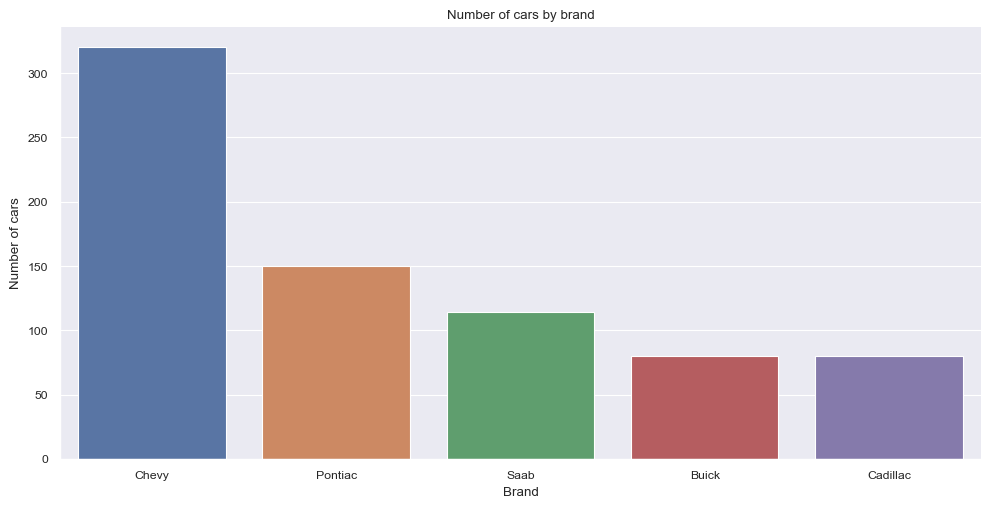

In [9]:
#| label: fig-brand
#| fig-cap: Number of cars by make

sns.catplot(
    data    = brands.sort_values('value', ascending=False),
    x       = 'variable',
    y       = 'value',
    kind    = 'bar',
    height  = 5,
    aspect  = 2,
)
plt.title('Number of cars by brand')
plt.xlabel('Brand')
plt.ylabel('Number of cars')
plt.show()

In descending order the most present make is: Chevy followed by Pontiac, Saab, Buick and Cadilac. 

At this point it should be mentioned, that the data set is not balanced and the distribution of the features is not uniform across the different makes and car features. In a normal project this would be a point to consider and to take care of. However, for the purpose of this project, this is not necessary. 

# Modeling
Modeling with `statsmodels` becomes straightforward once the formula API and provided documentation are well understood. I encountered a minor challenge in grasping the formula API, but once I comprehended it, the usage turned out to be quite intuitive. 

Let's delve into an understanding of the formula API (`statsmodels.formula.api`). This feature enables us to employ R-style formulas for specifying models. To illustrate, when fitting a linear model, the following formula suffices:

```python
import statsmodels.formula.api as smf

model = smf.ols(
    formula='y ~ x1 + x2 + x3', 
    data=df
)
```

The formula API leverages the `patsy` package ([Patsy Package](https://patsy.readthedocs.io/en/latest/formulas.html)). It's worth noting that the formula API's potency extends to intricate models. Additionally, it's important to mention that the formula API automatically incorporates an intercept into the formula if one isn't explicitly specified. For cases where the intercept is undesired, a `-1` can be used within the formula.

With the `glm` class, a vast array of models becomes accessible importing as follows:

```python
import statsmodels.genmod.families.family as fam
```

The `fam` import is necessary for specifying the family of the model. The families available are:

In [10]:
#| echo: false
#| output: true
#| label: tbl-glmFamilies
#| tbl-cap: GLM Families

from IPython.display import Markdown

glms = pd.read_html(
    #'https://www.statsmodels.org/stable/glm.html',
    'https://www.statsmodels.org/stable/glm.html#families',
)

families = glms[3]

Markdown(
    (
        families
        .rename(
            columns = {
                0 : 'Name',
                1 : 'Description',
            }
        )
        .to_markdown(
            index = False
        )
    )
)

| Name                                        | Description                                                |
|:--------------------------------------------|:-----------------------------------------------------------|
| Family(link, variance[, check_link])        | The parent class for one-parameter exponential families.   |
| Binomial([link, check_link])                | Binomial exponential family distribution.                  |
| Gamma([link, check_link])                   | Gamma exponential family distribution.                     |
| Gaussian([link, check_link])                | Gaussian exponential family distribution.                  |
| InverseGaussian([link, check_link])         | InverseGaussian exponential family.                        |
| NegativeBinomial([link, alpha, check_link]) | Negative Binomial exponential family (corresponds to NB2). |
| Poisson([link, check_link])                 | Poisson exponential family.                                |
| Tweedie([link, var_power, eql, check_link]) | Tweedie family.                                            |

Fitting the model and analyzing the results are the same as one would using `R`. First define the model, then fit it, then analyze the results. The details of the fit can be accessed using the `summary` method.

In [11]:
#| echo: false
#| output: true

variables = df.columns.to_list()

response_variable = variables.pop(0)
variables = variables

formula = 'Price ~' + ' + '.join(variables) + ' - 1'

model1 = (
    smf
    .glm(
        formula = formula, 
        offset  = None,
        data    = df, 
        family  = fam.Gaussian(),
        missing = 'drop',
    )
    .fit()
)

print(
    model1.summary()
)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Price   No. Observations:                  804
Model:                            GLM   Df Residuals:                      789
Model Family:                Gaussian   Df Model:                           14
Link Function:               Identity   Scale:                      8.4460e+06
Method:                          IRLS   Log-Likelihood:                -7544.8
Date:                Sun, 03 Sep 2023   Deviance:                   6.6639e+09
Time:                        21:02:49   Pearson chi2:                 6.66e+09
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Mileage        -0.1842      0.013    -14.664      

After fitting a GLM using the `glm` class in `statsmodels`, you can obtain a summary of the model's results using the `.summary()` method on the fitted model object. Here's a general overview of the information typically included in the summary output:

1. **Model Information:**
   - The name of the model.
   - The method used for estimation (e.g., maximum likelihood).
   - The distribution family (e.g., Gaussian, binomial, Poisson).
   - The link function used in the model (e.g., logit, identity, etc.).
   - The number of observations used in the model.

2. **Model Fit Statistics:**
   - Log-likelihood value.
   - AIC (Akaike Information Criterion) and/or BIC (Bayesian Information Criterion).
   - Deviance and Pearson chi-square statistics.
   - Dispersion parameter (if applicable).

3. **Coefficients:**
   - Estimated coefficients for each predictor variable.
   - Standard errors of the coefficients.
   - z-scores and p-values for testing the significance of the coefficients.

4. **Confidence Intervals:**
   - Confidence intervals for each coefficient, often at a default level like 95%.

5. **Hypothesis Testing:**
   - Hypothesis tests for the coefficients, typically with null hypothesis being that the coefficient is zero.

6. **Goodness of Fit:**
   - Likelihood-ratio test for overall model fit.
   - Tests for assessing the contribution of individual predictors to the model.

7. **Diagnostic Information:**
   - Information about model assumptions and diagnostics, depending on the type of GLM and the method used.

8. **Residuals:**
   - Information about residuals, which can include measures like deviance residuals, Pearson residuals, etc.

Refer to the official documentation for the most accurate and up-to-date information about the summary output for your specific use case.

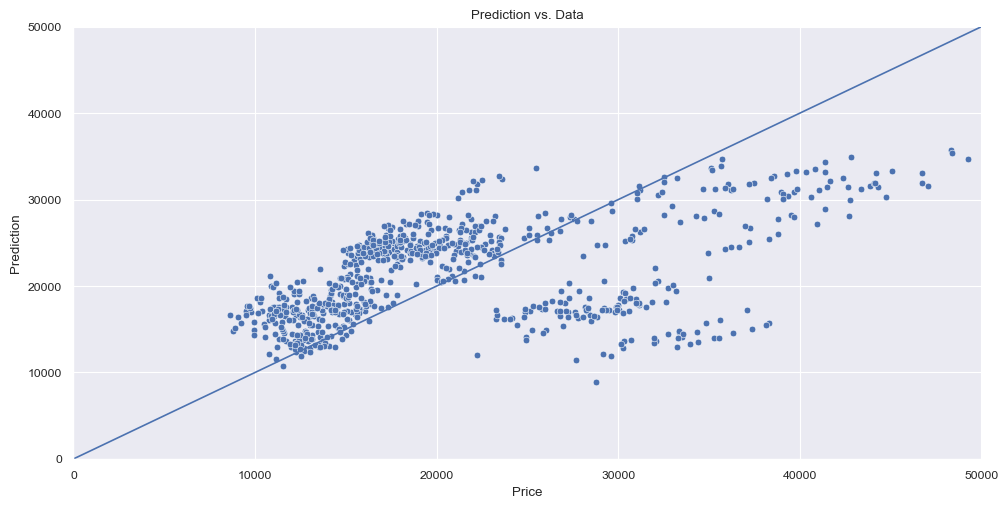

In [12]:
#| label: fig-preds_vs_data
#| fig-cap: Number of cars by make
#| output: false
#| include: false

preds = (
    df
    .assign(
        Price_pred = lambda df: model1.params.loc['Mileage'] * df.Mileage +  model1.params.loc['Cylinder'] * df.Cylinder + model1.params.loc['Doors'] * df.Doors,
        procent_error = lambda df: df.Price_pred / df.Price,
    )
)

height = plt.rcParams['figure.figsize'][0]
aspect = plt.rcParams['figure.figsize'][0]/plt.rcParams['figure.figsize'][1] / 2

g = sns.relplot(
    data    = preds,
    x       = 'Price',
    y       = 'Price_pred',
    height  = 5,
    aspect  = 2,
    kind    = 'scatter',
)
plt.xlim(0, 50000)
plt.ylim(0, 50000)
plt.xlabel('Price')
plt.ylabel('Prediction')
plt.axline((0,0),(1,1))
plt.title('Prediction vs. Data')
plt.show(g)

# Conclusion
Statsmodels is a powerful Python library for statistical modeling and hypothesis testing, making it an excellent transition for `R` users or Python users who like `R` to solve certain problems. It offers a familiar syntax and functionality for regression, ANOVA, and more. Its integration with Python's data analysis ecosystem, like pandas, allows seamless data manipulation. With support for various statistical methods and a comprehensive summary output, Statsmodels facilitates effortless migration from R, enabling R users to harness its capabilities in a Python environment.